# RAG System Component Evaluation
    
This notebook is a follow up from the previous [notebook](https://github.com/fhuthmacher/LLMevaluation/blob/main/LLMInformationExtraction.ipynb) and [youtube video](https://www.youtube.com/watch?v=HUuO9eJbOTk) in which we explored the overall evaluation approach and a RAG system's overall accuracy.

In this notebook we will take a closer look at specific RAG evaluation metrics and explore how to optimize different RAG components based these RAG evaluation metrics.


## Solution architecture
<img src="./images/architecture.png" alt="RAG eval architecture " width="800">

From the solution architecture, we will experiment with the below RAG components and parameters to optimize our RAG evalution metrics.

- Chunk Size: determines how a source text is stored in a knowledge base
- Chunking strategy / Text Splitter: TokenTextSplitter vs CharacterTextSplitter
- Embedding model: amazon.titan-embed-text-v1 vs cohere.embed-multilingual-v3 
- Retriever: OpenSearch VectoreStoreRetriever search types “similarity” vs “mmr” vs Bedrock KnowledgeBase retriever
- Prompt Template: set of instructions to guide the LLM’s response


## RAG evaluation metrics

This notebook covers the following metrics from Retrieval Augmented Generation Assessment (RAGAS):

-  context_precision: evaluates whether all of the ground-truth relevant items are present in the contexts are ranked higher or not. Ideally all the relevant chunks must appear at the top ranks. Values range from 0 to 1, higher scores indicate better precision.
-  context_recall: measures the extent to which the retrieved context aligns with the annotated answer, treated as the ground truth. Values range from 0 to 1, with higher values indicating better performance.
-  answer_relevancy: focuses on assessing how relevant the generated answer is to the given prompt. A lower score is assigned to answers that are incomplete or contain redundant information. This metric is computed using the question and the answer, with values ranging between 0 and 1 where higher scores indicate better relevancy.
-  answer_correctness¶: the accuracy of the generated answer when compared to the ground truth. This evaluation relies on the ground truth and the answer, with scores ranging from 0 to 1  where higher scores indicate better relevancy.
-  faithfulness: measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context. Values range from 0 to 1, with higher values indicating better performance.

Further information on RAG evaluation metrics with RAGAS can be found [here](https://docs.ragas.io/en/latest/concepts/metrics/index.html).


While this notebook tracks metrics with mlflow, it is not required for the evaluation. If you want to learn more about how to configure mlflow in your environment, please refer to this [AWS Blog](https://aws.amazon.com/blogs/machine-learning/securing-mlflow-in-aws-fine-grained-access-control-with-aws-native-services/).

In this notebook we use helper functions for illustration purposes. In production, this functionality would typically be part of an evaluation pipeline for example with Amazon SageMaker Pipelines.

<img src="./images/RAGevalmetrics.png" alt="RAG eval metrics" width="800">

In [2]:
# parse output of !conda env list and check if value rag_eval is part of it
import subprocess

# Run the command and capture its output
output = subprocess.check_output(["conda", "env", "list"])

# Decode the output from bytes to string
output = output.decode("utf-8")

# Split the output into lines
lines = output.split("\n")

# Iterate through the lines to find the environment names
environment_names = []
for line in lines:
    # Skip empty lines and lines not starting with a hash (#)
    if line.startswith("#") or not line.strip():
        continue
    # Split the line by whitespace and get the first element (environment name)
    environment_name = line.split()[0]
    environment_names.append(environment_name)

# Check if "rag_eval" is in the list of environment names
if "rag_eval" in environment_names:
    print("The environment 'rag_eval' is present.")
else:
    print("The environment 'rag_eval' is not present.")
    # Create a conda environment to encapsulate dependencies
    !conda env list
    !conda create -y --name rag_eval python=3.11.8 
    !conda init && activate rag_eval
    !conda install -y ipykernel

    # After installing new conda env, do a browser refresh and select new kernel and restart JupyterLab



The environment 'rag_eval' is present.


In [3]:
# check installed packages
with open('requirements.txt') as f:
  requirements = f.readlines()

import pkg_resources

installed_packages = [d for d in pkg_resources.working_set]

installed_packages = [package.project_name for package in installed_packages]

missing_packages = []

for requirement in requirements:
  requirement = requirement.strip().split('==')[0]
  if requirement not in installed_packages and requirement !='./ragas-aws-1.0.tar.gz':
    missing_packages.append(requirement)

if missing_packages:
  print(f"Missing packages: {', '.join(missing_packages)}")
else: 
  print("All packages are installed")



All packages are installed


In [4]:
# if there are any missing dependencies, install packages
if missing_packages:
    # install dependencies
    %pip install --force-reinstall --no-cache -r requirements.txt

In [5]:
#!pip install --upgrade jupyter-console
#!pip install --upgrade jupyter

In [6]:
# restart kernel to ensure proper version of libraries is loaded
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
if missing_packages:
    restartkernel()

In [7]:
!pip list | grep -E "awscli|boto3|botocore|langchain|llama-index|plotly|tiktoken|nltk|python-dotenv|ragas|requests-aws4auth|pypdf|opensearch-py|sagemaker|nest-asyncio"
# also review requirements.txt for specific package versions if needed

boto3                     1.34.87
botocore                  1.34.93
langchain                 0.1.16
langchain-aws             0.1.2
langchain-community       0.0.34
langchain-core            0.1.48
langchain-openai          0.1.4
langchain-text-splitters  0.0.1
langchainhub              0.1.15
nest-asyncio              1.6.0
nltk                      3.8.1
opensearch-py             2.4.2
plotly                    5.9.0
pypdf                     3.17.4
python-dotenv             1.0.0
ragas                     0.1.7
requests-aws4auth         1.2.3
sagemaker                 2.203.1
tiktoken                  0.5.2


In [8]:
# load environment variables 
import boto3
import os
import botocore
from botocore.config import Config
import langchain
import sagemaker
import pandas as pd

from langchain.llms.bedrock import Bedrock
from langchain.llms import SagemakerEndpoint
from langchain.llms.sagemaker_endpoint import LLMContentHandler
from typing import Dict

import json
import requests
import csv
import time
import pandas as pd
import nltk
import sys

from langchain.llms import Bedrock
from dotenv import load_dotenv, find_dotenv
import mlflow
from mlflow import MlflowClient


# loading environment variables that are stored in local file dev.env
load_dotenv(find_dotenv('dev-mlflow.env'),override=True)

os.environ['OPENSEARCH_COLLECTION'] = os.getenv('OPENSEARCH_COLLECTION')
os.environ['BEDROCK_KNOWLEDGEBASE_ID'] = os.getenv('BEDROCK_KNOWLEDGEBASE_ID')
os.environ['REGION'] = os.getenv('REGION')
os.environ['MLFLOW_TRACKING_ENABLED'] = os.getenv('MLFLOW_TRACKING_ENABLED')
os.environ['MLFLOW_TRACKING_URI'] = os.getenv('MLFLOW_TRACKING_URI')

if os.environ['MLFLOW_TRACKING_ENABLED'] == 'True':
   # Initialize mlflow client
   mlflow_client = MlflowClient(tracking_uri=os.environ['MLFLOW_TRACKING_URI'])


# Initialize Bedrock runtime
config = Config(
   retries = {
      'max_attempts': 10,
      'mode': 'standard'
   }
)
bedrock_runtime = boto3.client(
        service_name="bedrock-runtime",
        config=config
)

# Initialize sagemaker session
session = sagemaker.Session()
bucket = session.default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [9]:
# call bedrock to return list of all available models
bedrock_client = boto3.client(
        service_name="bedrock",
        config=config
)
response = bedrock_client.list_foundation_models()
for model in response['modelSummaries']:
        if model['modelLifecycle']['status'] == 'ACTIVE' and model['providerName'] == 'Anthropic': 
                print(model)


{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/anthropic.claude-instant-v1:2:100k', 'modelId': 'anthropic.claude-instant-v1:2:100k', 'modelName': 'Claude Instant', 'providerName': 'Anthropic', 'inputModalities': ['TEXT'], 'outputModalities': ['TEXT'], 'responseStreamingSupported': True, 'customizationsSupported': ['FINE_TUNING'], 'inferenceTypesSupported': ['PROVISIONED'], 'modelLifecycle': {'status': 'ACTIVE'}}
{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/anthropic.claude-instant-v1', 'modelId': 'anthropic.claude-instant-v1', 'modelName': 'Claude Instant', 'providerName': 'Anthropic', 'inputModalities': ['TEXT'], 'outputModalities': ['TEXT'], 'responseStreamingSupported': True, 'customizationsSupported': [], 'inferenceTypesSupported': ['ON_DEMAND'], 'modelLifecycle': {'status': 'ACTIVE'}}
{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/anthropic.claude-v2:0:18k', 'modelId': 'anthropic.claude-v2:0:18k', 'modelName': 'Claude', 'providerName': 'Anthropic

In [10]:
# Create a new mlflow experiment
import random

if os.environ['MLFLOW_TRACKING_ENABLED'] == 'True':
    experiment_description = (
        "RAG system evaluation project."
    )

    experiment_tags = {
        "project_name": "rag-eval",
        "use_case": "information extraction",
        "team": "aws-ai-ml-analytics",
        "source": "Amazon 10k",
        "mlflow.note.content": experiment_description,
    }

    random_identifier = random.randrange(100, 1000, 3)
    experiment_name = f"RAG_system_accuracy_{random_identifier}"

    # Use search_experiments() to search on the project_name tag key
    rag_experiment = mlflow_client.search_experiments(
        filter_string="tags.`project_name` = 'rag-eval'"
    )
    # check length of mlflow.store.entities.paged_list.PagedList
    # if experiment does not exist yet, create it
    if len(rag_experiment) == 0:
        rag_experiment = mlflow_client.create_experiment(name=experiment_name, tags=experiment_tags)
        print(rag_experiment)
else:
    experiment_name = 'not_tracked'


In [11]:
# 1. Initialize LLMs (Claude, Cohere, LLama)

## 1a. Initialize Claude
llm01_inference_modifier = {
    "max_tokens": 545, # Claude-3 use “max_tokens” However Claude-2 requires “max_tokens_to_sample”
    "temperature": 0.0,
    "top_k": 20,
    "top_p": 1,
    "stop_sequences": ["\n\nHuman"],
}
from langchain_aws import ChatBedrock #BedrockLLM
LLM_01_NAME = 'anthropic.claude-3-sonnet-20240229-v1:0'
llm01 = ChatBedrock(
    client=bedrock_runtime,
    model_id=LLM_01_NAME,
    model_kwargs=llm01_inference_modifier
)

## 1b. Initialize Cohere Command
llm02_inference_modifier = { 
    "max_tokens": 545,
    "top_k": 20,
    "temperature": 0,    
}
LLM_02_NAME= "cohere.command-text-v14"
llm02 = langchain.llms.bedrock.Bedrock( #create a Bedrock llm client
    model_id=LLM_02_NAME,
    model_kwargs=llm02_inference_modifier
)

## 1c. Initialize Llama
llm03_inference_modifier = { 
    "max_gen_len": 545,
    "top_p": 0.9, 
    "top_k": 20,
    "temperature": 0,    
}
LLM_03_NAME= "meta.llama2-13b-chat-v1"
llm03 = langchain.llms.bedrock.Bedrock( #create a Bedrock llm client
    model_id=LLM_03_NAME,
    model_kwargs=llm03_inference_modifier
)

llms = [
    llm01,
    llm02,
    llm03
]


/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `Bedrock` was deprecated in LangChain 0.0.34 and will be removed in 0.3. An updated version of the class exists in the langchain-aws package and should be used instead. To use it run `pip install -U langchain-aws` and import as `from langchain_aws import BedrockLLM`.
  warn_deprecated(


In [12]:
## 2. Download ground truth dataset

import xmltodict
url = 'https://d3q8adh3y5sxpk.cloudfront.net/rageval/qsdata_20.xml'

# Send an HTTP GET request to download the file
response = requests.get(url)

# Check if the request was successful (HTTP status code 200)
if response.status_code == 200:        
    xml_data = xmltodict.parse(response.text)

# Convert the dictionary to a Pandas DataFrame
qa_dataset = pd.DataFrame(xml_data['data']['records'])

prompts = []
for row in qa_dataset.itertuples():
    item = {
        'prompt': str(row[1]['Question']),
        'context': str(row[1]['Context']),
        'output': '<question_answer>' + str(row[1]['Answer']['question_answer']) + '</question_answer>',
        'page': str(row[1]['Page'])
    }
    prompts.append(item)

# example prompt
print(prompts[0])

{'prompt': "Who is Amazon's Senior Vice President and General Counsel?", 'context': 'Available Information\nOur investor relations website is amazon.com/ir and we encourage investors to use it as a way of easily finding information about us. We promptly make available on this website, free of charge, the reports that we file or furnish with the Securities and Exchange Commission (â\x80\x9cSECâ\x80\x9d), corporate governance information (including our Code of Business Conduct and Ethics), and select press releases.\nExecutive Officers and Directors\nThe following tables set forth certain information regarding our Executive Officers and Directors as of January 25, 2023:\nInformation About Our Executive Officers\nName Age Position\nJeffrey P. Bezos. Mr. Bezos founded Amazon.com in 1994 and has served as Executive Chair since July 2021. He has served as Chair of the Board since 1994 and served as Chief Executive Officer from May 1996 until July 2021, and as President from 1994 until June 1

In [13]:
# 3. Download context / Amazon annual report and create documents
import numpy as np
import pypdf
from langchain.text_splitter import CharacterTextSplitter, TokenTextSplitter, RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader
from urllib.request import urlretrieve

os.makedirs("data", exist_ok=True)
files = [ "https://d3q8adh3y5sxpk.cloudfront.net/rageval/AMZN-2023-10k.pdf"]
for url in files:
    file_path = os.path.join("data", url.rpartition("/")[2])
    urlretrieve(url, file_path)
    

loader = PyPDFDirectoryLoader("./data/")
documents = loader.load()

In [14]:
# 4. Create or get vector database (OpenSearch Serverless)
## Provisioning below resources requires signficant access. 
## Thus if you do not have admin access or already have an existing OpenSearch Serverless endpoint and Bedrock Knowledge Base, you can just update the corresponding variable in dev-mlflow.env

import time
import os
import dotenv
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

host = os.environ['OPENSEARCH_COLLECTION']  # serverless collection endpoint, without https://
#print(f"host: {host}")
region = os.environ['REGION']  # e.g. us-east-1
print(f'region: {region}')

service = 'aoss'
credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, region, service)

## 4a. create vectordatabase if it does not exist yet
if host == 'XXX':
    print('creating collection')
    vector_store_name = 'rag-eval'
    encryption_policy_name = "rag-eval-ep"
    network_policy_name = "rag-eval-np"
    access_policy_name = 'rag-eval-ap'
    identity = boto3.client('sts').get_caller_identity()['Arn']

    aoss_client = boto3.client('opensearchserverless')

    security_policy = aoss_client.create_security_policy(
        name = encryption_policy_name,
        policy = json.dumps(
            {
                'Rules': [{'Resource': ['collection/' + vector_store_name],
                'ResourceType': 'collection'}],
                'AWSOwnedKey': True
            }),
        type = 'encryption'
    )

    network_policy = aoss_client.create_security_policy(
        name = network_policy_name,
        policy = json.dumps(
            [
                {'Rules': [{'Resource': ['collection/' + vector_store_name],
                'ResourceType': 'collection'}],
                'AllowFromPublic': True}
            ]),
        type = 'network'
    )

    collection = aoss_client.create_collection(name=vector_store_name,type='VECTORSEARCH')

    while True:
        status = aoss_client.list_collections(collectionFilters={'name':vector_store_name})['collectionSummaries'][0]['status']
        if status in ('ACTIVE', 'FAILED'): 
            print(f'new collection {vector_store_name} created')
            break
        time.sleep(10)

    access_policy = aoss_client.create_access_policy(
        name = access_policy_name,
        policy = json.dumps(
            [
                {
                    'Rules': [
                        {
                            'Resource': ['collection/' + vector_store_name],
                            'Permission': [
                                'aoss:CreateCollectionItems',
                                'aoss:DeleteCollectionItems',
                                'aoss:UpdateCollectionItems',
                                'aoss:DescribeCollectionItems'],
                            'ResourceType': 'collection'
                        },
                        {
                            'Resource': ['index/' + vector_store_name + '/*'],
                            'Permission': [
                                'aoss:CreateIndex',
                                'aoss:DeleteIndex',
                                'aoss:UpdateIndex',
                                'aoss:DescribeIndex',
                                'aoss:ReadDocument',
                                'aoss:WriteDocument'],
                            'ResourceType': 'index'
                        }],
                    'Principal': [identity],
                    'Description': 'Easy data policy'}
            ]),
        type = 'data'
    )
    print(collection)
    host = collection['createCollectionDetail']['id'] + '.' + os.environ.get("AWS_DEFAULT_REGION", None) + '.aoss.amazonaws.com:443'
    host = host.split(":")[0].replace("'","")
    # Write changes to .env file.
    os.environ['OPENSEARCH_COLLECTION'] = host
    dotenv.set_key('dev-mlflow.env', "OPENSEARCH_COLLECTION", os.environ["OPENSEARCH_COLLECTION"])

aospy_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=auth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    pool_maxsize=20,
)

## 4b. create Bedrock KnowledgeBase if it does not exist yet

if os.environ['BEDROCK_KNOWLEDGEBASE_ID'] == "XXX":
    knowledge_base_id = ""
    session = sagemaker.Session()

    # please note this requires significant permissions, thus might have to be done outside of the notebook if your user role has insufficient access.
    print('create knowledge base')

    print(f'using the following S3 bucket as source: {bucket}')
    prefix = "bedrock-kb-eval"

    # upload source data to S3
    s3 = boto3.client('s3')
    s3.upload_file('./data/AMZN-2023-10k.pdf', bucket, 'rageval/AMZN-2023-10k.pdf')

    #session.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'rageval/AMZN-2023-10k.pdf')).upload_file('rageval/AMZN-2023-10k.pdf')

    knowledge_base_name = prefix
    knowledge_base_description = prefix
    
    knowledge_base_bucket_arn = f"arn:aws:s3:::{bucket}"
    # parse collection id
    collection_id = os.environ['OPENSEARCH_COLLECTION'].split(".")[0]
    account_id = boto3.Session().client('sts').get_caller_identity()['Account']

    collection_arn = f'arn:aws:aoss:{region}:{account_id}:collection/{collection_id}'
    embeddingModelArn = f"arn:aws:bedrock:{region}::foundation-model/amazon.titan-embed-text-v1"

    # create IAM role
    iam = boto3.client('iam')
    policy_doc = {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow", 
                "Action": [
                    "s3:GetObject",
                    "s3:PutObject",
                    "s3:ListBucket"
                ],
                "Resource": [
                    "arn:aws:s3:::{bucket}",
                    "arn:aws:s3:::{bucket}/*"  
                ]
            },
            {
                "Sid": "BedrockAll",
                "Effect": "Allow",
                "Action": [
                    "bedrock:*"
                ],
                "Resource": "*"
            },
            {
                "Sid": "PassRoleToBedrock",
                "Effect": "Allow",
                "Action": [
                    "iam:PassRole"
                ],
                "Resource": "arn:aws:iam::*:role/*AmazonBedrock*",
                "Condition": {
                    "StringEquals": {
                        "iam:PassedToService": [
                            "bedrock.amazonaws.com"
                        ]
                    }
                }
            },
            {
            "Effect": "Allow",
            "Action": [
                "aoss:APIAccessAll",
                "aoss:*"
            ],
            "Resource": f'arn:aws:aoss:{region}:{account_id}:collection/{collection_id}'
            }
        ]
        }
    import random
    random_identifier = random.randint(100,999)
    rolename = f'AmazonBedrockExecutionRoleForKnowledgeBase_rageval_{str(random_identifier)}'
    role = iam.create_role(
        RoleName=rolename,
        AssumeRolePolicyDocument=json.dumps({
            "Version": "2012-10-17",
            "Statement": [
                {
                    "Effect": "Allow",
                    "Principal": {
                    "Service": [
                        "bedrock.amazonaws.com",
                        "opensearchservice.amazonaws.com"
                    ]
                    },  
                    "Action": "sts:AssumeRole"
                }
            ]
        })
    )

    result = iam.put_role_policy(
        RoleName=rolename,
        PolicyName='AmazonBedrockExecutionRolePolicy',
        PolicyDocument=json.dumps(policy_doc)
    )
    role_details = iam.get_role(RoleName=rolename)

    knowledge_base_resource_role_arn = role_details['Role']['Arn']

    # create OpenSearch index
    index_name = prefix
    vector_field = "kb_vector"
    text_field = "kb_text"
    bedrock_metadata_field = "bedrock"
    vector_size = 1536

    index_found = False
    try:
        client.indices.get(index=index_name)
        index_found = True
    except:
        print("Index does not exist, create the index")

    #create a new index
    index_body = {
        "settings": {
            "index.knn": True
    },
    'mappings': {
        'properties': {
        f"{vector_field}": { "type": "knn_vector", "dimension": vector_size, "method": {"engine": "faiss", "space_type": "l2", "name": "hnsw", "parameters": {}   } },
        f"{text_field}": { "type": "text" },
        f"{bedrock_metadata_field}": { "type": "text", "index": False }
        }
    }
    }

    try:
        #print('trying to create new index')
        aospy_client.indices.delete(index=index_name)
        aospy_client.indices.create(index=index_name,body=index_body,ignore=400)
    except:
        #print(f'Index {index_name} not found. Creating index on OpenSearch.')
        aospy_client.indices.create(index=index_name,body=index_body)

    # wait 60 seconds for index creation to complete
    time.sleep(60)

    aospy_client.indices.get(index=index_name)

    print(f'knowledge_base_name: {knowledge_base_name}')
    print(f'knowledge_base_description: {knowledge_base_description}')
    print(f'knowledge_base_resource_role_arn: {knowledge_base_resource_role_arn}')
    print(f'embeddingModelArn: {embeddingModelArn}')
    print(f'collection_arn: {collection_arn}')
    print(f'index_name: {index_name}')
    print(f'vector_field: {vector_field}')
    print(f'text_field: {text_field}')
    print(f'bedrock_metadata_field: {bedrock_metadata_field}')
    # create knowledge base
    knowledge_base_config = {
        "name": knowledge_base_name,
        "description": knowledge_base_description,
        "roleArn":knowledge_base_resource_role_arn,
        "knowledgeBaseConfiguration": {
            "type": 'VECTOR',
            "vectorKnowledgeBaseConfiguration": {
                "embeddingModelArn": embeddingModelArn
            }
        },
        "storageConfiguration": {
            "type": 'OPENSEARCH_SERVERLESS',
            "opensearchServerlessConfiguration": {
                "collectionArn": collection_arn,
                "vectorIndexName": index_name,
                "fieldMapping": {
                    "vectorField": vector_field,
                    "textField": text_field,
                    "metadataField": bedrock_metadata_field
                }
            }
        }
    }
    bedrock_agent_client = boto3.client('bedrock-agent', region_name = region)
    if knowledge_base_id == "":
        response = bedrock_agent_client.create_knowledge_base(**knowledge_base_config)
        knowledge_base_id = response['knowledgeBase']['knowledgeBaseId']                      

    data_source_id = ""
    max_token_chunk = 8192
    overlap = 10

    response = bedrock_agent_client.list_data_sources(
        knowledgeBaseId=knowledge_base_id
    )
    for data_source in response['dataSourceSummaries']:
        if data_source['knowledgeBaseId'] == knowledge_base_id:
            data_source_id = data_source['dataSourceId']

    # configure data_source
    data_source_config = {
        "knowledgeBaseId": knowledge_base_id,
        "name": data_source_name,
        "description": data_source_name,
        "dataSourceConfiguration": {
            "type": 'S3',
            "s3Configuration": {
                "bucketArn": knowledge_base_bucket_arn,
                "inclusionPrefixes": [
                    "kb/",
                ]
            }
        },
        "vectorIngestionConfiguration": {
            "chunkingConfiguration": {
                "chunkingStrategy": "FIXED_SIZE",
                "fixedSizeChunkingConfiguration": {
                    "maxTokens": max_token_chunk,
                    "overlapPercentage": overlap
                }
            }
        }
    }

    ds_response = bedrock_agent_client.create_data_source(**data_source_config)
    data_source_id = ds_response['dataSource']['dataSourceId']
    
    response = bedrock_agent_client.list_data_sources( knowledgeBaseId=knowledge_base_id)
    for data_source in response['dataSourceSummaries']:
        if data_source['knowledgeBaseId'] == knowledge_base_id:
            data_source_id = data_source['dataSourceId']

    print(f"data_source_id: {data_source_id}")

    ingestion_response = bedrock_agent_client.start_ingestion_job(knowledgeBaseId=knowledge_base_id,dataSourceId=data_source_id)
    print(f"ingestion response: {ingestion_response}")
    
    ingestion_job = ingestion_response['ingestionJob']['ingestionJobId']
    print(f"ingestionJobId: {ingestion_job}")
    status = 'IN_PROGRESS'
    response = {}
    
    while status == 'IN_PROGRESS':
        response = bedrock_agent_client.get_ingestion_job(
            knowledgeBaseId=knowledge_base_id,
            dataSourceId=data_source_id,
            ingestionJobId=ingestion_job
        )
        
        status = response['ingestionJob']['status']
        time.sleep(5)
    
    print(response['ingestionJob']['statistics'])

    # Write changes to .env file.
    os.environ['BEDROCK_KNOWLEDGEBASE_ID'] = knowledge_base_id
    dotenv.set_key('dev-mlflow.env', "BEDROCK_KNOWLEDGEBASE_ID", os.environ["BEDROCK_KNOWLEDGEBASE_ID"])

region: us-east-1


In [15]:
# 5. Create and save prompt templates for evaluation

from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain import hub

### Claude prompt templates
# Template 1: Long prompt with XML tags context chunks, and step by step instructions, and reiterating how the response should be provided in the end.
prompt_template_claude_1 = """
        Human: 
        You are a helpful, respectful, and honest research assistant, dedicated to providing valuable and accurate information.
        You will be provided with a report extract between <report></report> XML tags, please read it and analyse the content.
        Please answer the following question: 
        {question} 
        
        The answer must only be based on the information from the report.
        Return the answer inside <question_answer></question_answer> XML tags.

        If a particular bit of information is not present, return "There is not enough information available to answer this question" inside the XML tags.
        Each returned answer should be concise, remove extra information if possible.
        The report will be given between <report></report> XML tags.

        <report>
        {context}
        </report>

        Return the answer inside <question_answer></question_answer> XML tags.
        Assistant:"""

PROMPT_CLAUDE_1 = PromptTemplate(
    template=prompt_template_claude_1, input_variables=["question", "context"]
)

# Template 2: InContextLearning prompt with example interaction between Human and Assistant
prompt_template_claude_2 = """
        Human: 
        You are a helpful, respectful, and honest research assistant, dedicated to providing valuable and accurate information.

        Assistant:
        Understood. I will provide information based on the context given, without relying on prior knowledge.

        Human:
        If you don't see answer in the context just reply "There is not enough information available to answer this question" in XML tags.

        Assistant:
        Noted. I will respond with "There is not enough information available to answer this question" if the information is not available in the context.

        Human:
        Return the answer inside <question_answer></question_answer> XML tags. 

        Assistant:
        I will provide the answer inside <question_answer></question_answer> XML tags.

        Human:
        Now read and analyse the context provided in <report></report> XML tags carefully.
        <report>
        {context}
        </report>
        Then answer the below question:
        {question}

        Assistant:<question_answer>
        """

PROMPT_CLAUDE_2 = PromptTemplate(
    template=prompt_template_claude_2, input_variables=["question", "context"]
)

### Llama2 prompt templates
prompt_template_llama_1 = """
        [INST] Given report provided, please read it and analyse the content.
        Please answer the following question: {question} basing the answer only on the information from the report
        and return it inside <question_answer></question_answer> XML tags.

        If a particular bit of information is not present, return an empty string.
        Each returned answer should be concise, remove extra information if possible.
        The report will be given between <report></report> XML tags.

        <report>
        {context}
        </report>

        Return the answer inside <question_answer></question_answer> XML tags. [/INST]
        """
PROMPT_LLAMA_1 = PromptTemplate(
    template=prompt_template_llama_1, input_variables=["question", "context"]
)

prompt_template_llama_2 = """
        [INST]
        You are a helpful, respectful, and honest assistant, dedicated to providing valuable and accurate information.
        [/INST]

        Understood. I will provide information based on the context given, without relying on prior knowledge.

        [INST]
        If you don't see answer in the context just reply "not available" in XML tags.
        [/INST]

        Noted. I will respond with "not available" if the information is not available in the context.

        [INST]
        Now read this context and answer the question and return the answer inside <question_answer></question_answer> XML tags. 
        {context}
        [/INST]

        Based on the provided context above and information from the retriever source, I will provide the answer in  and return it inside <question_answer></question_answer> XML tags to the below question
        {question}
        """
PROMPT_LLAMA_2 = PromptTemplate(
    template=prompt_template_llama_2, input_variables=["question", "context"]
)


### Cohere Command prompt templates
prompt_template_command_1 = """
        Human: Given report provided, please read it and analyse the content.
        Please answer the following question: {question} basing the answer only on the information from the report
        and return it inside <question_answer></question_answer> XML tags.

        If a particular bit of information is not present, return an empty string.
        Each returned answer should be concise, remove extra information if possible.
        The report will be given between <report></report> XML tags.

        <report>
        {context}
        </report>

        Return the answer inside <question_answer></question_answer> XML tags.
        Assistant:"""

PROMPT_COMMAND_1 = PromptTemplate(
    template=prompt_template_command_1, input_variables=["question", "context"]
)

prompt_template_command_2 = """
        Human: 
        You are a helpful, respectful, and honest assistant, dedicated to providing valuable and accurate information.

        Assistant:
        Understood. I will provide information based on the context given, without relying on prior knowledge.

        Human:
        If you don't see answer in the context just reply "not available" in XML tags.

        Assistant:
        Noted. I will respond with "not available" if the information is not available in the context.

        Human:
        Now read this context and answer the question and return the answer inside <question_answer></question_answer> XML tags. 
        {context}

        Assistant:
        Based on the provided context above and information from the retriever source, I will provide the answer in  and return it inside <question_answer></question_answer> XML tags to the below question
        {question}
        """
PROMPT_COMMAND_2 = PromptTemplate(
    template=prompt_template_command_2, input_variables=["question", "context"]
)

# generic prompt template for all LLMs
generic_rag_template = hub.pull("rlm/rag-prompt")

prompttemplates = [
    {'template_name': 'generic_rag_template', 'template': generic_rag_template},
    {'template_name': 'prompt_template_claude_1', 'template': PROMPT_CLAUDE_1},
    {'template_name': 'prompt_template_claude_2', 'template': PROMPT_CLAUDE_2},
    {'template_name': 'prompt_template_command_1', 'template': PROMPT_COMMAND_1},
    {'template_name': 'prompt_template_command_2', 'template': PROMPT_COMMAND_2},
    {'template_name': 'prompt_template_llama_1', 'template': PROMPT_LLAMA_1},
    {'template_name': 'prompt_template_llama_2', 'template': PROMPT_LLAMA_2},
]

## 6) Create 2 helper functions:
### 6a. create_rag to create RAG systems for evaluation
### 6b. run_ragas_eval to evaluate RAG system with RAGAS and LlamaIndex evaluators

In [16]:
# 6a. helper function to create RAG systems for evaluation

import random
from langchain.embeddings import BedrockEmbeddings
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.vectorstores import OpenSearchVectorSearch
from langchain.retrievers.bedrock import AmazonKnowledgeBasesRetriever
import time

# # LangChain requires AWS4Auth
from requests_aws4auth import AWS4Auth
def get_aws4_auth():
    region = os.environ.get("Region", os.environ["REGION"])
    service = "aoss"
    credentials = boto3.Session().get_credentials()
    print(credentials)
    return AWS4Auth(
        credentials.access_key,
        credentials.secret_key,
        region,
        service,
        session_token=credentials.token,
    )
aws4_auth = get_aws4_auth()


def create_rag(rag_system_details, debug):
    from langchain_core.globals import set_debug
    # if you run into any error, set langchain debug to true
    if debug == True:
        set_debug(True)
    else:
        set_debug(False)
        
    existing_vector_store = rag_system_details["vector_store"]
    kb_id = rag_system_details["kb_id"]
    llm = rag_system_details["llm"]
    aospy_client = rag_system_details["aospy_client"]
    embedding_model = rag_system_details["embedding_model"]
    embedding_model_name = rag_system_details["embedding_model_name"]
    splitter_name = rag_system_details["splitter_name"]
    text_chunks = rag_system_details["text_chunks"]
    index_name = rag_system_details["index_name"]
    index_dimension = rag_system_details["index_dimension"]
    prompt_template_name = rag_system_details["prompt_template_name"]
    prompt_template = rag_system_details["prompt_template"]
    chain_type= rag_system_details["chain_type"]
    search_type= rag_system_details["search_type"]
    retriever_k = rag_system_details["retriever_k"]
    score_threshold = rag_system_details["score_threshold"]
    fetch_k = rag_system_details["fetch_k"]
    lambda_mult = rag_system_details["lambda_mult"]
    vector_store = ""
    if existing_vector_store == "" and kb_id == "":
        # create index
        knn_index = {
            "settings": {
                "index.knn": True
            },
            "mappings": {
                "properties": {
                    "vector_field": {
                        "type": "knn_vector",
                        "method": {
                        "engine": "faiss",
                        "name": "hnsw",
                        "space_type": "l2"
                        },
                        "dimension": index_dimension,
                        "store": True
                    },
                    "text": {
                        "type": "text",
                        "store": True
                    },
                }
            }
        }

        try:
            #print('trying to create new index')
            aospy_client.indices.delete(index=index_name)
            aospy_client.indices.create(index=index_name,body=knn_index,ignore=400)
            aospy_client.indices.get(index=index_name)
        except:
            #print(f'Index {index_name} not found. Creating index on OpenSearch.')
            aospy_client.indices.create(index=index_name,body=knn_index)
            aospy_client.indices.get(index=index_name)

        # generate embeddings
        full_opensearch_endpoint = 'https://' + os.environ['OPENSEARCH_COLLECTION']
        vector_store = OpenSearchVectorSearch.from_documents(
                    index_name = index_name,
                    documents = text_chunks,
                    embedding = embedding_model,
                    opensearch_url=full_opensearch_endpoint,
                    http_auth=auth,
                    use_ssl=True,
                    verify_certs=True,
                    connection_class=RequestsHttpConnection,
                    timeout=60*3,
                    bulk_size=4000,
                    is_aoss=True
                )

        # add a wait timer, otherwise index is not ready in time for retrieval
        time.sleep(60)
    if existing_vector_store != "" and kb_id == "":
        print(f'use existing vector store: {existing_vector_store}')
        vector_store = existing_vector_store

    random_identifier = random.randrange(100, 1000, 3)

    if kb_id == "":
        run_name=f'LLM_{llm.model_id}_embeddings{embedding_model_name}_split_{splitter_name}_template_{prompt_template_name}_search_{search_type}_chain_{chain_type}_k_{retriever_k}_{random_identifier}'
        search_kwargs = {
            "retriever_k": retriever_k
        }
        retriever = vector_store.as_retriever(search_type = search_type, search_kwargs=search_kwargs)
    else:
        # use Bedrock Knowledgebase retriever
        print(f'using kb_id: {kb_id}')
        run_name=f'LLM_{llm.model_id}_embeddings{embedding_model_name}_split_{splitter_name}_template_{prompt_template_name}_kb_id_{kb_id}_k_{retriever_k}_{random_identifier}'
        retriever = AmazonKnowledgeBasesRetriever(
                knowledge_base_id=kb_id,
                retrieval_config={"vectorSearchConfiguration": {"numberOfResults": retriever_k}},

            )

    qa_chain = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type=chain_type,
            retriever=retriever,
            return_source_documents=True,
            chain_type_kwargs = {"prompt": prompt_template}
    )
    
    return run_name, vector_store, qa_chain


In [17]:
# 6b. helper function to evaluate RAG system with RAGAS

import mlflow
from mlflow.data.pandas_dataset import PandasDataset
from datasets import Dataset
import ragas
#import tqdm as notebook_tqdm
from ragas import evaluate
from ragas.metrics import (
    context_precision,
    faithfulness,
    context_recall,
    answer_relevancy,
    answer_correctness,
    #answer_similarity,
    #context_relevancy
)
from langchain_core.globals import set_debug
import nest_asyncio

nest_asyncio.apply()


inference_modifier = {
    "max_tokens_to_sample": 545, # Claude-3 use “max_tokens” However Claud-2 requires “max_tokens_to_sample”
    "temperature": 0.0,
    "top_k": 20,
    "top_p": 1,
    "stop_sequences": ["\n\nHuman"],
}
eval_llm_id = 'anthropic.claude-v2'

ragas_eval_llm = langchain.llms.bedrock.Bedrock(
    client=bedrock_runtime,
    model_id=eval_llm_id,
    model_kwargs=inference_modifier,
    #streaming=True
)

from langchain.embeddings import BedrockEmbeddings
ragas_eval_embedding = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="amazon.titan-embed-text-v1"
)


def run_ragas_eval(rag_system_eval_details, rag_system_details, debug):
    # if you run into any error, set langchain debug to true
    if debug == True:
        set_debug(True)
    else:
        set_debug(False)

    mlflow_metrics_results = {}
    experiment_name = rag_system_eval_details["experiment_name"]
    run_name = rag_system_eval_details["run_name"]
    qa_chain = rag_system_eval_details["qa_chain"]
    ground_truth = rag_system_eval_details["ground_truth"]
        
    metrics = [
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
        answer_correctness,
        #answer_similarity,
        #context_relevancy
        
    ]

    basic_qa_ragas_dataset = []
    basic_error_log = []
    for item in ground_truth:
        generated_answer_error = ""
        retrieved_context_error = ""
        reference_answer_error = ""
        
        result = qa_chain.invoke(item['prompt'])
        #print(f'result: {result}')

        question = item['prompt']
        reference_answer = item['output']
        generated_answer = result["result"]

        context_sequence = []
        for doc in result["source_documents"]:
            context_sequence.append(doc.page_content)
        retrieved_context = context_sequence

        if generated_answer is None or generated_answer.strip() == "" or generated_answer.replace(" ", "") == "<question_answer></question_answer>":
            generated_answer_error = f'no answer generated for question {question}'
            
        if retrieved_context is None or retrieved_context == "" or retrieved_context == "[]" or len(context_sequence) == 0 :
            retrieved_context_error = f'no retrieved_context for question {question}'
        
        if reference_answer is None or reference_answer == "":
            reference_answer_error = f'no reference_answer for question {question}'
                
        
        if generated_answer_error != "" or retrieved_context_error != "" or reference_answer_error != "":
            basic_error_log.append(
                {"question" : question,
                "generated_answer_error" : generated_answer_error,
                "retrieved_context_error" : retrieved_context_error,
                "reference_answer_error" : reference_answer_error,
                "value_error": ""
                }
            )
        else:
            
            basic_qa_ragas_dataset.append(
                {"question" : item['prompt'],
                "answer" : result["result"],
                "contexts" : context_sequence,
                "ground_truth" : item['output']
                }
            )

    
    #capture any errors in CSV for further review
    if len(basic_error_log) != 0:
        basic_error_log_df = pd.DataFrame(basic_error_log)
        basic_error_log_df.to_csv('./mlflow_run_errorlog.csv',index=False)
    
    if len(basic_qa_ragas_dataset) != 0:
        basic_qa_ragas_df = pd.DataFrame(basic_qa_ragas_dataset)
        basic_qa_ragas_df.to_csv('./mlflow_run_predictions.csv',index=False)

        # evaluate with RAGAS
        basic_qa_ragas = Dataset.from_pandas(basic_qa_ragas_df)
        
        ragas_result = evaluate(basic_qa_ragas, metrics=metrics, llm=ragas_eval_llm, embeddings=ragas_eval_embedding,raise_exceptions=False ) #old: evaluate(basic_qa_ragas, metrics=metrics)
        
        ragas_evals_df = ragas_result.to_pandas()

        params = {
            "run_name": run_name,
            "llm_name": rag_system_details["llm"].model_id,
            "kb_id": rag_system_details["kb_id"],
            "splitter_name": rag_system_details["splitter_name"],
            "index_name": rag_system_details["index_name"],
            "index_dimension": rag_system_details["index_dimension"],
            "embedding_model_name": rag_system_details["embedding_model_name"],
            "prompt_template_name": rag_system_details["prompt_template_name"],
            "chain_type": rag_system_details["chain_type"],
            "search_type": rag_system_details["search_type"],
            "retriever_k": rag_system_details["retriever_k"],
            "score_threshold": rag_system_details["score_threshold"],
            "fetch_k": rag_system_details["fetch_k"],
            "lambda_mult": rag_system_details["lambda_mult"]
        }
        
        print(f'ragas_faithfulness mean: {ragas_evals_df["faithfulness"].mean()}')
        print(f'ragas_answer_relevancy mean: {ragas_evals_df["answer_relevancy"].mean()}')
        print(f'ragas_context_recall mean:: {ragas_evals_df["context_recall"].mean()}')
        print(f'ragas_context_precision mean: {ragas_evals_df["context_precision"].mean()}')
        #print(f'ragas_context_relevancy mean: {ragas_evals_df["context_relevancy"].mean()}')
        #print(f'ragas_answer_similarity mean: {ragas_evals_df["answer_similarity"].mean()}')
        print(f'ragas_answer_correctness mean: {ragas_evals_df["answer_correctness"].mean()}')

        mlflow_metrics_results = {
            "ragas_faithfulness_mean": ragas_evals_df["faithfulness"].mean(),
            "ragas_answer_relevancy_mean": ragas_evals_df["answer_relevancy"].mean(),
            "ragas_context_recall_mean": ragas_evals_df["context_recall"].mean(),
            "ragas_context_precision_mean": ragas_evals_df["context_precision"].mean(),
            # "ragas_context_relevancy_mean": ragas_evals_df["context_relevancy"].mean(),
            # "ragas_answer_similarity_mean": ragas_evals_df["answer_similarity"].mean(),
            "ragas_answer_correctness_mean": ragas_evals_df["answer_correctness"].mean(),

        }

        if os.environ['MLFLOW_TRACKING_ENABLED'] == 'True':
            llm_experiment = mlflow.set_experiment(experiment_name)
            # Initiate the MLflow run context
            with mlflow.start_run(run_name=run_name) as run:
                # Log input dataset to MLflow Tracking as a JSON artifact.
                mlflow_dataset = mlflow.data.from_pandas(basic_qa_ragas_df, source='./mlflow_run_predictions.csv')
                mlflow.log_input(mlflow_dataset, context="rag-output")

                # Log evaluation metrics that were calculated
                mlflow.log_metrics(mlflow_metrics_results)
                
                # Log RAGAS results to MLflow Tracking as a JSON artifact.
                mlflow.log_table(data=ragas_evals_df, artifact_file="qa_ragas_eval_results.json")

                # Log parameters used for the RAG system
                mlflow.log_params(params)

    return mlflow_metrics_results, ragas_evals_df

In [18]:
# 6c. helper function to analyse RAGAS results with an LLM

# have an LLM analyse the results
import boto3
import json
import base64

def analze_ragas_result_chart(image_path, comparison):
    with open(image_path, "rb") as image_file:
        image_b64_string = base64.b64encode(image_file.read()).decode("utf-8")

    # Variables for Bedrock API
    modelId = 'anthropic.claude-3-haiku-20240307-v1:0' #'anthropic.claude-3-sonnet-20240229-v1:0'
    contentType = 'application/json'
    accept = 'application/json'
    prompt = """The chart shows a comparison of the mean RAGAS metrics for faithfulness, answere relevance, answer correctness, context recall, and context precision. Follow the below instructions.
                1. Analyse the chart carefully.
                2. Determine which option performs best across all RAGAS metrics and include the result in the response in <best_overall></best_overall> xml tags.
                3. Determine a use case and reason why someone might want to proceed with the option and why this option performed better compared to the other options ({comparison}). Include the reason in no more than 150 words in the response <best_overall_reason></best_overall_reason> xml tags.
                3. Determine which option performs best if the metrics are prioritized in the followind order: 
                1)context recall,  2)context precision, 3)faithfulness, 4)answer relevance, 5)answer correctness. 
                Include the result in the response in <best_prioritized></best_prioritized> xml tags. 
                4. Determine a use case and reason why someone might want to proceed with this option and why this option performed better compared to the other options ({comparison}). Include the reason in no more than 150 words in the response <best_prioritized_reason></best_prioritized_reason> xml tags."""

    # Messages
    messages = [
    {
        "role": "user",
        "content": [
        {
            "type": "image",
            "source": {
            "type": "base64",
            "media_type": "image/png",
            "data": image_b64_string
            }
        },
        {
            "type": "text",
            "text": prompt
        }
        ]
    }
    ]

    # Body
    body = json.dumps({
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 1000,
        "messages": messages
    })

    # Run Bedrock API
    response = bedrock_runtime.invoke_model(
    modelId=modelId,
    contentType=contentType,
    accept=accept,
    body=body
    )

    response_body = json.loads(response.get('body').read())

    return response_body['content'][0]['text']

In [19]:
# 7. test a RAG system

char_text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
char_text_list = char_text_splitter.split_documents(documents)

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "RecursiveCharacterTextSplitter",
    "text_chunks": char_text_list,
    "index_name": "rag-eval-chartextsplitter",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details,debug=False)
query = "Who is Amazon's Senior Vice President and General Counsel?"
result = qa_chain.invoke(query)
print(result)

{'query': "Who is Amazon's Senior Vice President and General Counsel?", 'result': '<question_answer>David A. Zapolsky</question_answer>', 'source_documents': [Document(page_content='Executive Officers and Directors\nThe following tables set forth certain information regarding our Executive Officers and Directors as of January 25, 2023:\nInformation About Our Executive Officers\nName Age Position\nJeffrey P. Bezos 59 Executive Chair\nAndrew R. Jassy 55 President and Chief Executive Officer\nDouglas J. Herrington 56 CEO Worldwide Amazon Stores\nBrian T. Olsavsky 59 Senior Vice President and Chief Financial Officer', metadata={'source': 'data/AMZN-2023-10k.pdf', 'page': 4}), Document(page_content='2021, and Senior Vice President, Amazon Web Services, from April 2006 until April 2016.\nDouglas J. Herrington. Mr. Herrington has served as CEO Worldwide Amazon Stores since July 2022, Senior Vice President, North America Consumer\nfrom January 2015 to July 2022, and Senior Vice President, Cons

## 8) RAG system component evaluation

### 8.1) Evaluate impact of different chunk sizes

In this first eval, we keep everything else constant, and only change the chunk size.
One word tends to be about 2-3 tokens, a paragraph is about 128 tokens.
We test perform two experiments:

In the first experiment we evaluate the best chunk size for a TokenTextSplitter. We test chunk sizes of 128, 256, 512, and 1536 tokens (which is the context window limit for the embeddings model).

In the second experiment we evaluate the best chunk size for a RecursiveCharacterTextSplitter. Here the chunk size is defined as the maximum number of characters per chunk, not the number of tokens/words. Given that we are working with rather large documents such as 10k reports, we experiment with chunk sizes of 1000, 1500, 2000, and 2500 for LangChain's RecursiveCharacterTextSplitter.

In [20]:
# 8.1.1.1 Chunk Size Eval with chunk_size=128, chunk_overlap=64

token_text_splitter = TokenTextSplitter(chunk_size=128, chunk_overlap=64) 
token_text_list = token_text_splitter.split_documents(documents)  
print("TokenTextSplitter split documents in to " + str(len(token_text_list)) + " chunks.\n")

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter128",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter-128",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details,debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_resultchunk1,ragas_eval_resultchunk1df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

TokenTextSplitter split documents in to 904 chunks.



Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 120, in parse_partial_json
    return json.loads(s, strict=strict)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/h

ragas_faithfulness mean: 0.9047619047619048
ragas_answer_relevancy mean: 0.7788325783135304
ragas_context_recall mean:: 0.6547619047338623
ragas_context_precision mean: 0.5534340455192175
ragas_answer_correctness mean: 0.7122376561086744


In [21]:
# 8.1.1.2 Chunk Size Eval with chunk_size=256, chunk_overlap=64

token_text_splitter = TokenTextSplitter(chunk_size=256, chunk_overlap=64) 
token_text_list = token_text_splitter.split_documents(documents)  
print("TokenTextSplitter split documents in to " + str(len(token_text_list)) + " chunks.\n")

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter256",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter-256",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details,debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}

ragas_eval_resultchunk2,ragas_eval_resultchunk2df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

TokenTextSplitter split documents in to 328 chunks.



Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/

ragas_faithfulness mean: 0.7185416517901744
ragas_answer_relevancy mean: 0.7535714285697619
ragas_context_recall mean:: 0.5433571230639143
ragas_context_precision mean: 0.5284144790410183
ragas_answer_correctness mean: 0.6784048270089688


In [22]:
# 8.1.1.3 Chunk Size Eval with chunk_size=512, chunk_overlap=64

token_text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=64) 
token_text_list = token_text_splitter.split_documents(documents)  
print("TokenTextSplitter split documents in to " + str(len(token_text_list)) + " chunks.\n")

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter512",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter-512",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details, debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}

ragas_eval_resultchunk3,ragas_eval_resultchunk3df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

TokenTextSplitter split documents in to 167 chunks.



Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
The LLM did not return a valid classification.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
 

ragas_faithfulness mean: 0.8333333333333334
ragas_answer_relevancy mean: 0.6634233267165648
ragas_context_recall mean:: 0.7301587301448412
ragas_context_precision mean: 0.47530594077689986
ragas_answer_correctness mean: 0.49955319920679403


In [23]:
# 8.1.1.4 Chunk Size Eval with chunk_size=1024, chunk_overlap=64

token_text_splitter = TokenTextSplitter(chunk_size=1536, chunk_overlap=64) 
token_text_list = token_text_splitter.split_documents(documents)  
print("TokenTextSplitter split documents in to " + str(len(token_text_list)) + " chunks.\n")

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter1024",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter-1024",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details,debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}

ragas_eval_resultchunk4,ragas_eval_resultchunk4df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

TokenTextSplitter split documents in to 81 chunks.



Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 120, in parse_partial_json
    return json.loads(s, strict=strict)
    

ragas_faithfulness mean: 0.6147382210575775
ragas_answer_relevancy mean: 0.5703986116555261
ragas_context_recall mean:: 0.7435325093835503
ragas_context_precision mean: 0.7821683073265706
ragas_answer_correctness mean: 0.6852992741525809


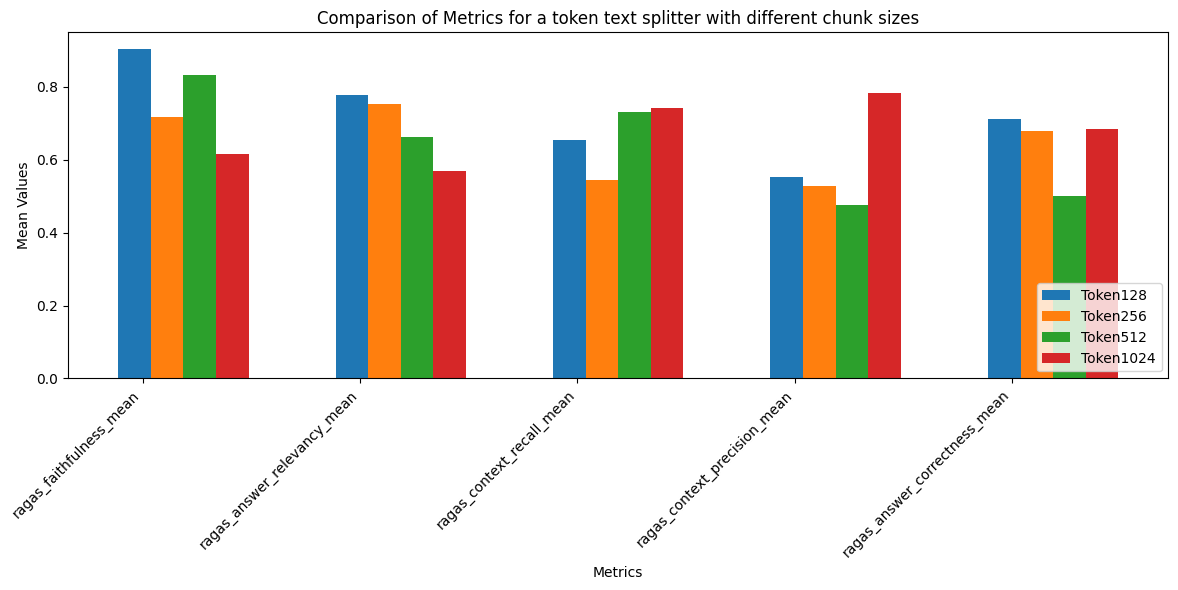

In [24]:
## 8.1.1.5 Review chunk size test results
import matplotlib.pyplot as plt


# Extract metric names and mean values
metric_names = list(ragas_eval_resultchunk1.keys())
ragas_eval_result1_means = list(ragas_eval_resultchunk1.values())
ragas_eval_result2_means = list(ragas_eval_resultchunk2.values())
ragas_eval_result3_means = list(ragas_eval_resultchunk3.values())
ragas_eval_result4_means = list(ragas_eval_resultchunk4.values())

# Create comparison chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.15
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result1_means, bar_width, label='Token128')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result2_means, bar_width, label='Token256')
bar3 = ax.bar([i + 2*bar_width for i in index], ragas_eval_result3_means, bar_width, label='Token512')
bar4 = ax.bar([i + 3*bar_width for i in index], ragas_eval_result4_means, bar_width, label='Token1024')

ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics for a token text splitter with different chunk sizes')
ax.set_xticks([i + bar_width / 4 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend(loc='lower right')

plt.tight_layout()

# Save the figure
filename = 'tokensplitter_chunksizes.png'
plt.savefig(filename)

plt.show()

In [25]:
# 8.1.1.6 LLM analysis
image_path = "tokensplitter_chunksizes.png"
comparison = 'token splitter chunk size of 128 vs 256 vs 512 vs 1024'
result = analze_ragas_result_chart(image_path, comparison)
print(result)

<best_overall>Token1024</best_overall>

<best_overall_reason>Based on the chart, Token1024 performs the best across all RAGAS metrics compared to the other token text splitter options. It has the highest scores for faithfulness, answer relevance, answer correctness, context recall, and context precision. This suggests that Token1024 is the most effective at preserving the meaning and context of the original text while also providing the most relevant and accurate responses. This could be beneficial in applications where maintaining the integrity of the original text is crucial, such as in legal or financial domains where precise and trustworthy information is critical.</best_overall_reason>

<best_prioritized>Token1024</best_prioritized>

<best_prioritized_reason>If the metrics are prioritized as 1) context recall, 2) context precision, 3) faithfulness, 4) answer relevance, and 5) answer correctness, then Token1024 still emerges as the best performer. It has the highest scores for cont

### 8.1.1.7 Review token splitter chunk size test results
Token1024 performs the best overall across all RAGAS metrics, and is also performing best across our prioritized set of metrics. This indicates that a chunk size of 1024 is the most well-rounded option for a token text splitter and more importantly is also a good option for our use case in which the preservation of the original text's context and meaning is of utmost importance. The 1024 chunk size performed well in all context related metrics, and combined with its strong faithfulness scores, ensures that the output of the text splitter maintains the essential characteristics of the original text, making it an ideal choice for this use case.

In [26]:
# 8.1.2.1 Chunk Size Eval with chunk_size=1000, chunk_overlap=64

char_text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=128)
char_text_list = char_text_splitter.split_documents(documents)
print("RecursiveCharacterTextSplitter split documents in to " + str(len(char_text_list)) + " chunks.\n")

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "RecursiveCharacterTextSplitter1000",
    "text_chunks": char_text_list,
    "index_name": "rag-eval-charactertextplitter-1000",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details,debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_resultcharchunk1,ragas_eval_resultcharchunk1df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

RecursiveCharacterTextSplitter split documents in to 345 chunks.



Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 120, in parse_partial_json
    return json.loads(s, strict=strict)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/py

ragas_faithfulness mean: 0.5978835978494489
ragas_answer_relevancy mean: 0.7533875849402752
ragas_context_recall mean:: 0.4628141021981224
ragas_context_precision mean: 0.6136815696431034
ragas_answer_correctness mean: 0.5923951499471207


In [27]:
# 8.1.2.2 Chunk Size Eval with chunk_size=1500, chunk_overlap=64

char_text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=128)
char_text_list = char_text_splitter.split_documents(documents)
print("RecursiveCharacterTextSplitter split documents in to " + str(len(char_text_list)) + " chunks.\n")

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "RecursiveCharacterTextSplitter1500",
    "text_chunks": char_text_list,
    "index_name": "rag-eval-charactertextplitter-1500",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details,debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_resultcharchunk2,ragas_eval_resultcharchunk2df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

RecursiveCharacterTextSplitter split documents in to 230 chunks.



Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eva

ragas_faithfulness mean: 0.561111111087824
ragas_answer_relevancy mean: 0.7653061224489794
ragas_context_recall mean:: 0.556536598890501
ragas_context_precision mean: 0.6206311082284415
ragas_answer_correctness mean: 0.851873725951689


In [28]:
# 8.1.2.3 Chunk Size Eval with chunk_size=2000, chunk_overlap=64

char_text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=128)
char_text_list = char_text_splitter.split_documents(documents)
print("RecursiveCharacterTextSplitter split documents in to " + str(len(char_text_list)) + " chunks.\n")

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "RecursiveCharacterTextSplitter2000",
    "text_chunks": char_text_list,
    "index_name": "rag-eval-charactertextplitter-2000",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details,debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_resultcharchunk3,ragas_eval_resultcharchunk3df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

RecursiveCharacterTextSplitter split documents in to 188 chunks.



Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/

ragas_faithfulness mean: 0.5552410313926239
ragas_answer_relevancy mean: 0.628660375167938
ragas_context_recall mean:: 0.44956723935798504
ragas_context_precision mean: 0.7429805189063947
ragas_answer_correctness mean: 0.6312682326065691


In [29]:
# 8.1.2.4 Chunk Size Eval with chunk_size=2500, chunk_overlap=64

char_text_splitter = RecursiveCharacterTextSplitter(chunk_size=2500, chunk_overlap=128)
char_text_list = char_text_splitter.split_documents(documents)
print("RecursiveCharacterTextSplitter split documents in to " + str(len(char_text_list)) + " chunks.\n")

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "RecursiveCharacterTextSplitter2500",
    "text_chunks": char_text_list,
    "index_name": "rag-eval-charactertextplitter-2500",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details,debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_resultcharchunk4,ragas_eval_resultcharchunk4df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

RecursiveCharacterTextSplitter split documents in to 155 chunks.



Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eva

ragas_faithfulness mean: 0.6499999999925
ragas_answer_relevancy mean: 0.6748473759231869
ragas_context_recall mean:: 0.6410008950912965
ragas_context_precision mean: 0.42590990835350134
ragas_answer_correctness mean: 0.6850495917143246


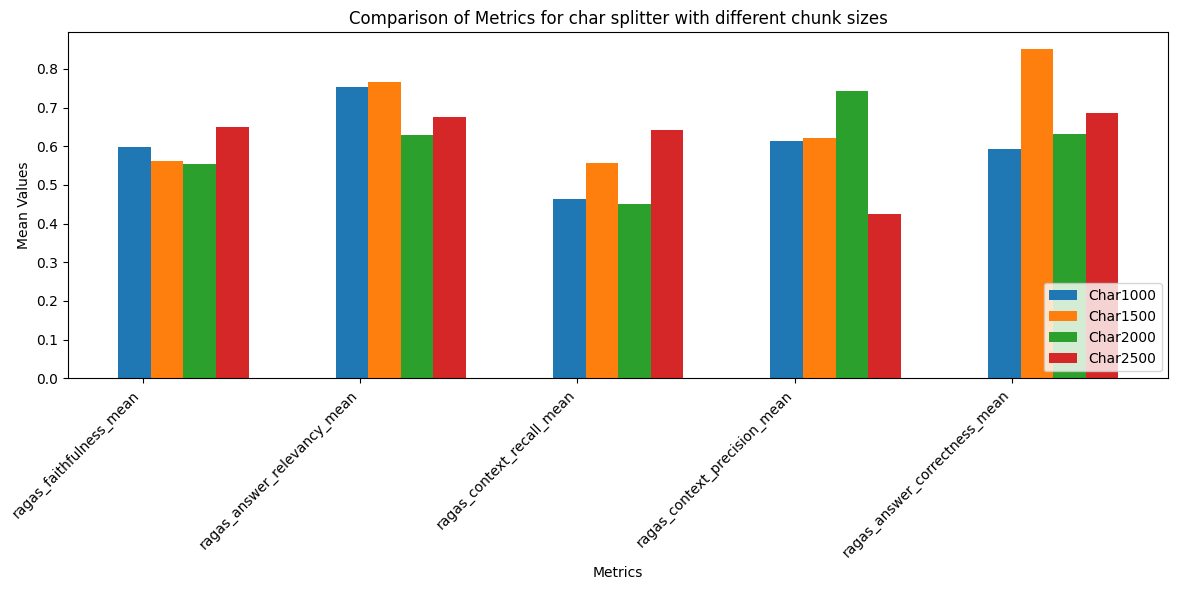

In [30]:
## 8.1.2.5 Review chunk size test results
import matplotlib.pyplot as plt


# Extract metric names and mean values
metric_names = list(ragas_eval_resultcharchunk1.keys())
ragas_eval_result1_means = list(ragas_eval_resultcharchunk1.values())
ragas_eval_result2_means = list(ragas_eval_resultcharchunk2.values())
ragas_eval_result3_means = list(ragas_eval_resultcharchunk3.values())
ragas_eval_result4_means = list(ragas_eval_resultcharchunk4.values())

# Create comparison chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.15
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result1_means, bar_width, label='Char1000')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result2_means, bar_width, label='Char1500')
bar3 = ax.bar([i + 2*bar_width for i in index], ragas_eval_result3_means, bar_width, label='Char2000')
bar4 = ax.bar([i + 3*bar_width for i in index], ragas_eval_result4_means, bar_width, label='Char2500')

ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics for char splitter with different chunk sizes')
ax.set_xticks([i + bar_width / 4 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend(loc='lower right')

plt.tight_layout()

# Save the figure
filename = 'charsplitter_chunksizes.png'
plt.savefig(filename)

plt.show()

In [31]:
# 8.1.2.6 LLM analysis
image_path = "charsplitter_chunksizes.png"
comparison = 'recursive character text splitter chunk size of 1000 vs 1500 vs 2000 vs 2500'
result = analze_ragas_result_chart(image_path, comparison)
print(result)


<best_overall>Char2000</best_overall>

<best_overall_reason>The Char2000 option appears to perform the best overall across all the RAGAS metrics compared to the other chunk sizes. It has the highest scores for faithfulness, answer relevance, and answer correctness, and performs reasonably well on the context-based metrics. This suggests that the Char2000 option would be a good choice for applications where a balanced performance across all these metrics is important, such as in a general-purpose conversational AI system that needs to provide relevant, accurate, and trustworthy responses.</best_overall_reason>

<best_prioritized>Char2000</best_prioritized>

<best_prioritized_reason>If the priority is to optimize for context recall, context precision, faithfulness, answer relevance, and answer correctness in that order, the Char2000 option still performs the best. It has the highest scores for context recall and context precision, and also performs well on the other metrics. This suggest

### 8.1.2.7 Review recursive character text splitter chunk size test results
Char2000 performs the best overall across all RAGAS metrics, and is also performing best across our prioritized set of metrics.

### 8.1.3 chunk size test results
Token1536 and Char2000 performed best in this experiment, this is why we will compare the two in the next experiment below.

### 8.2) Evaluate impact of different text splitters

In this second eval, we keep everything else constant, and only change the splitter method.

In [43]:
# 8.2.1 RAG system with TokenTextSplitter

token_text_splitter = TokenTextSplitter(chunk_size=1024, chunk_overlap=64) 
token_text_list = token_text_splitter.split_documents(documents)  
print("TokenTextSplitter split documents in to " + str(len(token_text_list)) + " chunks.\n")

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter1024",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter-1024",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details, debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}

ragas_eval_resultsplitter1,ragas_eval_resultsplitter1df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

TokenTextSplitter split documents in to 98 chunks.



Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/

ragas_faithfulness mean: 0.6541666666228472
ragas_answer_relevancy mean: 0.8285376820665775
ragas_context_recall mean:: 0.5361606522084252
ragas_context_precision mean: 0.550777768691623
ragas_answer_correctness mean: 0.7473263007020648


In [44]:
# 8.2.2 RAG system with CharTextSplitter

char_text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=64)
char_text_list = char_text_splitter.split_documents(documents)
print("CharacterTextSplitter split documents in to " + str(len(char_text_list)) + " chunks.\n")

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "RecursiveCharacterTextSplitter-2000",
    "text_chunks": char_text_list,
    "index_name": "rag-eval-charactertextplitter-2000",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details, debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_resultsplitter2,ragas_eval_resultsplitter2df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

CharacterTextSplitter split documents in to 186 chunks.



Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return p

ragas_faithfulness mean: 0.5861352413205179
ragas_answer_relevancy mean: 0.6311785441562032
ragas_context_recall mean:: 0.4139350453862797
ragas_context_precision mean: 0.7102702944971373
ragas_answer_correctness mean: 0.6074587087970452


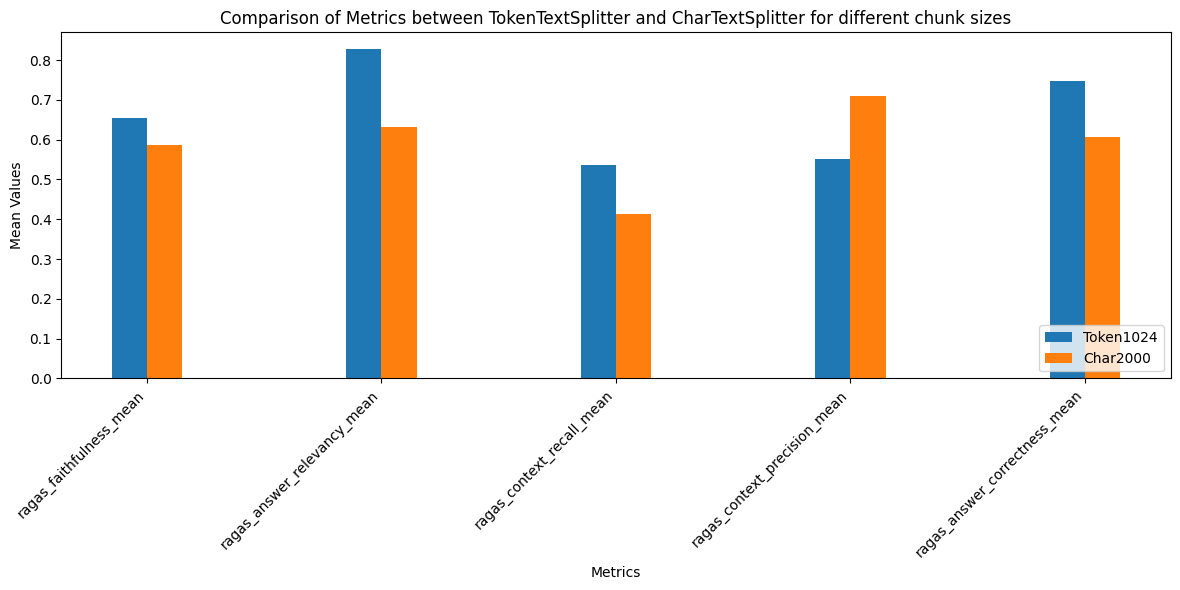

In [47]:
## 8.2.3 Review RecursiveCharacterTextSplitter vs TokenTextSplitter results
import matplotlib.pyplot as plt

# Extract metric names and mean values
metric_names = list(ragas_eval_resultsplitter1.keys())
ragas_eval_result1_means = list(ragas_eval_resultsplitter1.values())
ragas_eval_result2_means = list(ragas_eval_resultsplitter2.values())


# Create comparison chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.15
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result1_means, bar_width, label='Token1024')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result2_means, bar_width, label='Char2000')

ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics between TokenTextSplitter and CharTextSplitter for different chunk sizes')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend(loc='lower right')

plt.tight_layout()
# Save the figure
filename = 'tokensplitter_vs_charsplitter.png'
plt.savefig(filename)
plt.show()


In [48]:
# 8.2.4 LLM analysis
image_path = "tokensplitter_vs_charsplitter.png"
comparison = 'recursive character text splitter with a chunk size of 2000 vs a token text splitter with a chunk size of 1024'
result = analze_ragas_result_chart(image_path, comparison)
print(result)

<best_overall>Token1024</best_overall>

<best_overall_reason>
The chart shows that Token1024 consistently outperforms Char2000 across all RAGAS metrics, including faithfulness, answer relevance, answer correctness, context recall, and context precision. This suggests that Token1024 may be a better choice for use cases where maintaining high performance across multiple quality dimensions is important, such as building a high-quality conversational AI system. The stronger performance of Token1024 could be attributed to its more advanced text processing capabilities or a more robust training process, making it a more versatile and well-rounded option compared to Char2000.
</best_overall_reason>

<best_prioritized>Token1024</best_prioritized>

<best_prioritized_reason>
If the key priority is to maximize context recall, context precision, faithfulness, answer relevance, and answer correctness in that order, then Token1024 would be the best performing option. The chart shows that Token1024 o

### 8.2.5 Review RecursiveCharacterTextSplitter vs TokenTextSplitter results
The TokenTextSplitter outperformed the RecursiveCharacterTextSplitter across the prioritized set of metrics. 

### 8.3) Evaluate impact of different embeddings models

In this third eval, we proceed with the TokenTextSplitter, leave the  everything else constannt, and only change the embeddings models.
Due to the context window length of the cohere model, we had to adjust the chunk size for the Cohere model to 350.

In [49]:
# 8.3.1 Create RAG system with amazon.titan-embed-text-v1
from langchain.embeddings import BedrockEmbeddings

token_text_splitter = TokenTextSplitter(chunk_size=1024, chunk_overlap=64) 
token_text_list = token_text_splitter.split_documents(documents)  
print("TokenTextSplitter split documents in to " + str(len(token_text_list)) + " chunks.\n")

embedding_model = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="amazon.titan-embed-text-v1"
)

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter_1024",
    "index_dimension": 1536,
    "embedding_model_name": 'amazon.titan-embed-text-v1',
    "embedding_model": embedding_model,
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details, debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}

ragas_eval_resultembedding1,ragas_eval_resultembedding1df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)


TokenTextSplitter split documents in to 98 chunks.



Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 120, in parse_partial_jso

ragas_faithfulness mean: 0.5958333332941667
ragas_answer_relevancy mean: 0.8713557275507465
ragas_context_recall mean:: 0.544207535215526
ragas_context_precision mean: 0.551667534061413
ragas_answer_correctness mean: 0.7708960050058239


In [67]:
# 8.3.2 Create RAG system with cohere.embed-multilingual-v3
from langchain.embeddings import BedrockEmbeddings

token_text_splitter = TokenTextSplitter(chunk_size=350, chunk_overlap=16) 
token_text_list = token_text_splitter.split_documents(documents)  
print("TokenTextSplitter split documents in to " + str(len(token_text_list)) + " chunks.\n")

embedding_model = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="cohere.embed-multilingual-v3"
)


rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter350",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter_350",
    "index_dimension": 1024,
    "embedding_model_name": 'cohere.embed-multilingual-v3',
    "embedding_model": embedding_model,
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details, debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}

ragas_eval_resultembedding2,ragas_eval_resultembedding2df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

TokenTextSplitter split documents in to 218 chunks.



Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 120, in parse_partial_jso

ragas_faithfulness mean: 0.8676470588235294
ragas_answer_relevancy mean: 0.6237977225910347
ragas_context_recall mean:: 0.8877551020408163
ragas_context_precision mean: 0.5999999999479166
ragas_answer_correctness mean: 0.5654491567645644


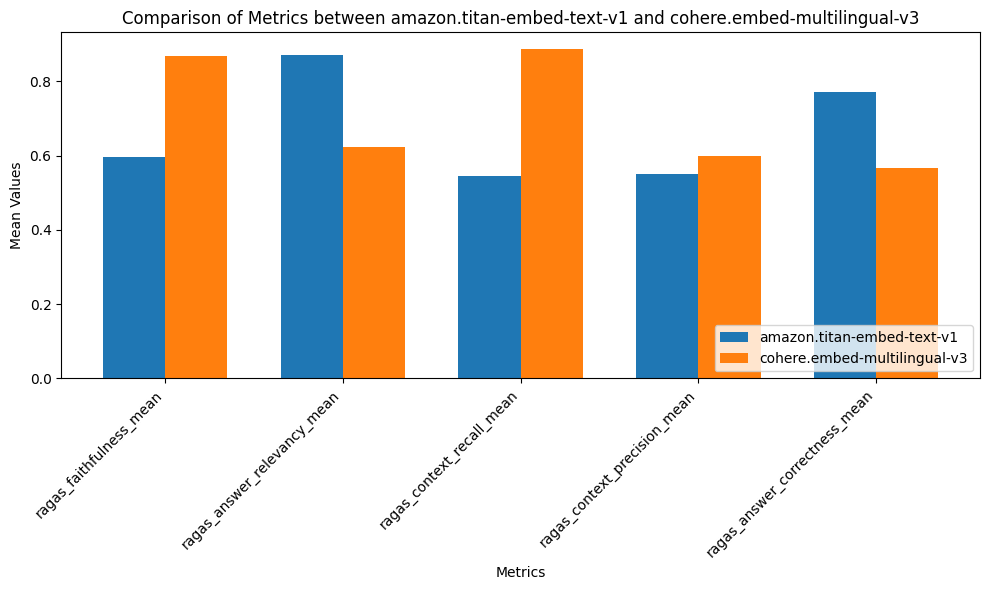

In [68]:
# 8.3.3 Review Embedding model: amazon.titan-embed-text-v1 vs cohere.embed-multilingual-v3 results

import matplotlib.pyplot as plt

# Extract metric names and mean values
metric_names = list(ragas_eval_resultembedding1.keys())
ragas_eval_result1_means = list(ragas_eval_resultembedding1.values())
ragas_eval_result2_means = list(ragas_eval_resultembedding2.values())

# Create comparison chart
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result1_means, bar_width, label='amazon.titan-embed-text-v1')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result2_means, bar_width, label='cohere.embed-multilingual-v3')

ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics between amazon.titan-embed-text-v1 and cohere.embed-multilingual-v3')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend(loc='lower right')

plt.tight_layout()

# Save the figure
filename = 'embeddingmodels_comparison.png'
plt.savefig(filename)

plt.show()

In [69]:
# 8.3.4 LLM analysis
image_path = "embeddingmodels_comparison.png"
comparison = 'Comparing the amazon.titan-embed-text-v1 embedding model with a chunk size of 1024 against a cohere.embed-multilingual-v3 embedding model with a chunk size of 350'
result = analze_ragas_result_chart(image_path, comparison)
print(result)

Here is my analysis of the chart:

<best_overall>cohere.embed-multilingual-v3</best_overall>

<best_overall_reason>
The cohere.embed-multilingual-v3 model performs best across all the RAGAS metrics compared to the amazon.titan-embed-text-v1 model. It has higher scores in faithfulness, answer relevance, answer correctness, context recall, and context precision. This makes the cohere.embed-multilingual-v3 model a more well-rounded and robust choice for applications that require high performance across multiple important metrics, such as chatbots, question-answering systems, or multilingual text processing. The superior performance of this model can be attributed to its multilingual capabilities and advanced training on a diverse corpus of data.
</best_overall_reason>

<best_prioritized>cohere.embed-multilingual-v3</best_prioritized>

<best_prioritized_reason>
If the metrics are prioritized in the order of context recall, context precision, faithfulness, answer relevance, and answer corre

### 8.3.5 Review Embedding model: amazon.titan-embed-text-v1 vs cohere.embed-multilingual-v3 results
Here we can observe that for context recall, context precision, and faithfulness cohere.embed-multilingual-v3 performs better than amazon.titan-embed-text-v1 with a 350 token chunk size.
 
As a result, we will proceed the next eval with cohere.embed-multilingual-v3 .

### 8.4) Evaluate impact of different retriever search types

In [70]:
# 8.4.1 Create RAG system with Opensearch's “similarity” retriever
from langchain.embeddings import BedrockEmbeddings

token_text_splitter = TokenTextSplitter(chunk_size=350, chunk_overlap=16) 
token_text_list = token_text_splitter.split_documents(documents)  
print("TokenTextSplitter split documents in to " + str(len(token_text_list)) + " chunks.\n")

embedding_model = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="cohere.embed-multilingual-v3"
)

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter-350",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter_350",
    "index_dimension": 1024,
    "embedding_model_name": 'cohere.embed-multilingual-v3',
    "embedding_model": embedding_model,
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details, debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_resultretriever1, ragas_eval_resultretriever1df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

TokenTextSplitter split documents in to 218 chunks.



Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/

ragas_faithfulness mean: 0.8676470588235294
ragas_answer_relevancy mean: 0.6271761683848601
ragas_context_recall mean:: 0.8877551020408163
ragas_context_precision mean: 0.5999999999479166
ragas_answer_correctness mean: 0.5623916297920166


In [71]:
# 8.4.2 Create RAG system with Opensearch's “mmr” retriever
from langchain.embeddings import BedrockEmbeddings

embedding_model = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="cohere.embed-multilingual-v3"
)

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": vector_store,
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter-350",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter_350",
    "index_dimension": 1024,
    "embedding_model_name": 'cohere.embed-multilingual-v3',
    "embedding_model": embedding_model,
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "mmr", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details, debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_resultretriever2, ragas_eval_resultretriever2df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

use existing vector store: <langchain_community.vectorstores.opensearch_vector_search.OpenSearchVectorSearch object at 0x7f09eae24c10>


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 120, in parse_partial_json
    return json.loads(s, strict=strict)
    

ragas_faithfulness mean: 0.8443877551020409
ragas_answer_relevancy mean: 0.8355661636824184
ragas_context_recall mean:: 0.65416666660625
ragas_context_precision mean: 0.530878890856863
ragas_answer_correctness mean: 0.6482149476313674


In [72]:
# 8.4.3 Create RAG system with Bedrock Knowledge Base retriever
from langchain.embeddings import BedrockEmbeddings

embedding_model = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="cohere.embed-multilingual-v3"
)

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
    "splitter_name": "TokenTextSplitter-350",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter_350",
    "index_dimension": 1024,
    "embedding_model_name": 'cohere.embed-multilingual-v3', # Bedrock KB will use same embeddings model
    "embedding_model": embedding_model,
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "mmr", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details, debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_resultretriever3, ragas_eval_resultretriever3df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

using kb_id: DYWCBEJD0V


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 120, in parse_partial_json
    return json.loads(s, strict=strict)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/py

ragas_faithfulness mean: 0.9102040816326531
ragas_answer_relevancy mean: 0.7771034061076935
ragas_context_recall mean:: 0.8412698412237434
ragas_context_precision mean: 0.6884701120375202
ragas_answer_correctness mean: 0.7082091727361908


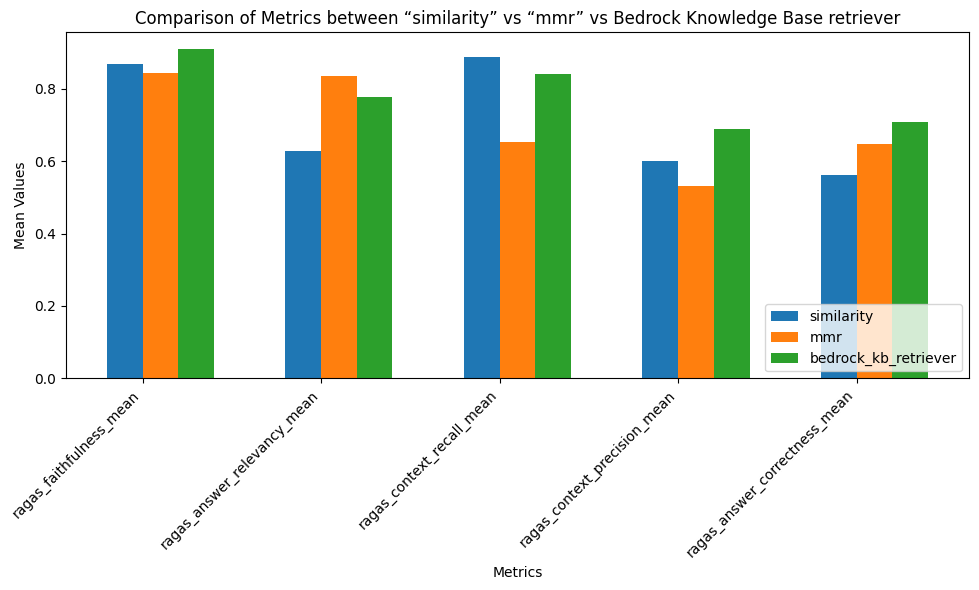

In [74]:
# 8.4.4 Review “similarity” vs “mmr” vs Bedrock Knowledge Base retriever results

import matplotlib.pyplot as plt


# Extract metric names and mean values
metric_names = list(ragas_eval_resultretriever1.keys())
ragas_eval_result1_means = list(ragas_eval_resultretriever1.values())
ragas_eval_result2_means = list(ragas_eval_resultretriever2.values())
ragas_eval_result3_means = list(ragas_eval_resultretriever3.values())

# Create comparison chart
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.20
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result1_means, bar_width, label='similarity')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result2_means, bar_width, label='mmr')
bar3 = ax.bar([i + 2*bar_width for i in index], ragas_eval_result3_means, bar_width, label='bedrock_kb_retriever')
ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics between “similarity” vs “mmr” vs Bedrock Knowledge Base retriever')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend(loc='lower right')

plt.tight_layout()
# Save the figure
filename = 'retriever_comparison.png'
plt.savefig(filename)
plt.show()

In [76]:
# 8.4.5 LLM analysis
image_path = "retriever_comparison.png"
comparison = 'Comparing similarity with mmr and bedrock_kb retriever'
result = analze_ragas_result_chart(image_path, comparison)
print(result) 

<best_overall>bedrock_kb_retriever</best_overall>

<best_overall_reason>
The bedrock_kb_retriever option appears to perform the best overall across all the RAGAS metrics compared to the other two options, "similarity" and "mmr". The bedrock_kb_retriever consistently outperforms the other two options in terms of faithfulness, answer relevance, answer correctness, context recall, and context precision. This makes the bedrock_kb_retriever a strong candidate for use cases that require a high-performing knowledge retrieval system that can accurately and faithfully extract relevant information from a knowledge base, while also providing contextual understanding and precision. This well-rounded performance across the key RAGAS metrics suggests the bedrock_kb_retriever could be a preferred choice for applications that demand reliable, high-quality information retrieval.
</best_overall_reason>

<best_prioritized>bedrock_kb_retriever</best_prioritized>

<best_prioritized_reason>
If the metrics a

### 8.4.6 Review “similarity” vs “mmr” vs Bedrock Knowledge Base retriever results

Bedrock's Knowledge Base Retriever with the Cohere embeddings model and default settings emerges as the best retriever.



### 8.5) Evaluate impact of different prompt templates

In [77]:
# 8.5.1 Create RAG system with PROMPT_CLAUDE_1
from langchain.embeddings import BedrockEmbeddings

embedding_model = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="cohere.embed-multilingual-v3"
)

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": vector_store,
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter_1024",
    "index_dimension": 1024,
    "embedding_model_name": 'cohere.embed-multilingual-v3',
    "embedding_model": embedding_model,
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "mmr", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details, debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}

ragas_eval_resultprompt1, ragas_eval_resultprompt1df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 120, in parse_partial_json
    return json.loads(s, strict=strict)
    

ragas_faithfulness mean: 0.8443877551020409
ragas_answer_relevancy mean: 0.8351692754418325
ragas_context_recall mean:: 0.65416666660625
ragas_context_precision mean: 0.5227540111398621
ragas_answer_correctness mean: 0.6473431682897258


In [78]:
# 8.5.2 Create RAG system with PROMPT_CLAUDE_2
from langchain.embeddings import BedrockEmbeddings

embedding_model = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="cohere.embed-multilingual-v3"
)

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": vector_store,
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter_1024",
    "index_dimension": 1024,
    "embedding_model_name": 'cohere.embed-multilingual-v3',
    "embedding_model": embedding_model,
    "prompt_template_name": "PROMPT_CLAUDE_2",
    "prompt_template": PROMPT_CLAUDE_2,
    "chain_type": "stuff",
    "search_type": "mmr", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details, debug=False)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_resultprompt2, ragas_eval_resultprompt2df = run_ragas_eval(rag_system_eval_details, rag_system_details, debug=False)

use existing vector store: <langchain_community.vectorstores.opensearch_vector_search.OpenSearchVectorSearch object at 0x7f09e29a4590>


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/output_parsers/json.py", line 66, in parse_result
    return parse_json_markdown(text)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 147, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 160, in _parse_json
    return parser(json_str)
           ^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/langchain_core/utils/json.py", line 120, in parse_partial_json
    return json.loads(s, strict=strict)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/h

ragas_faithfulness mean: 0.60416666662125
ragas_answer_relevancy mean: 0.7967687074829932
ragas_context_recall mean:: 0.708404478731165
ragas_context_precision mean: 0.6829425304373197
ragas_answer_correctness mean: 0.7500021488107415


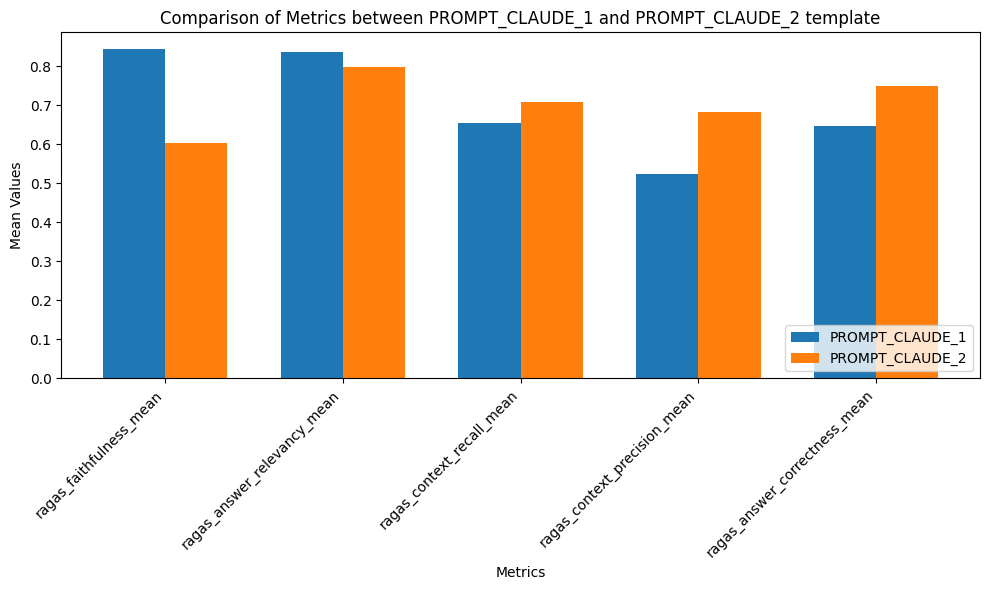

In [80]:
# 8.5.3 Review PROMPT_CLAUDE_1 vs PROMPT_CLAUDE_2 results

import matplotlib.pyplot as plt
  
# Extract metric names and mean values
metric_names = list(ragas_eval_resultprompt1.keys())
ragas_eval_result1_means = list(ragas_eval_resultprompt1.values())
ragas_eval_result2_means = list(ragas_eval_resultprompt2.values())

# Create comparison chart
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result1_means, bar_width, label='PROMPT_CLAUDE_1')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result2_means, bar_width, label='PROMPT_CLAUDE_2')

ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics between PROMPT_CLAUDE_1 and PROMPT_CLAUDE_2 template')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend(loc='lower right')

plt.tight_layout()
# Save the figure
filename = 'prompttemplate_comparison.png'
plt.savefig(filename)

plt.show()

### 8.5.4 Review PROMPT_CLAUDE_1 vs PROMPT_CLAUDE_2 results

Overall comparable performance between the two prompt templates. Other factors such as prompt length/cost should be considered in addition to the above performance results.


# Conclusion

In our benchmark here, a token text splitter with a chunk size of 350 and a chunk overlap of 16 worked well in combination with Cohere's embeddings model and Bedrock KnowledgeBase's retriever. Bedrock's Knowledge Base Retriever with Cohere embeddings model and default settings performed even slightly better across our prioritized RAGAS metrics compared to LangChain’s OpenSearch retriever with similarity or mmr search type on the given dataset.

But more important than the specific benchmark results above, we established that there is no one size fits all approach and instead demonstrated a metric driven development approach to optimize the retrieval performance of a RAG system, which you can apply to your own data, RAG system, and use case.


# Things to improve

- Compare more advanced retrieval methods
- Compare single and multi-language embeddings models
- Compare more advanced prompt templates
- Include cost dimension in analysis